In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import Timestamp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:

START_DATE = '2022-01-01'
END_DATE = '2022-12-31'
INITIAL_CAPITAL = 100000000

# Parâmetros VWAP
VWAP_PERIOD = 20
STOP_LOSS = 0.02
TAKE_PROFIT = 0.05

In [3]:
# Calcular VWAP rolling
def calcular_vwap_rolling(group):
    group['PV'] = group['Preco_Tipico'] * group['Volume']
    group['VWAP'] = (
        group['PV'].rolling(window=10, min_periods=1).sum() /
        group['Volume'].rolling(window=10, min_periods=1).sum()
    )
    return group

In [4]:
def df_to_dict(df):
    """
    Converte DataFrame consolidado em dicionário por ativo
    """
    data = {}

    for ativo in df['Ativo'].unique():
        # Filtrar dados do ativo
        df_ativo = df[df['Ativo'] == ativo].copy()

        # Remover coluna Ativo
        df_ativo = df_ativo.drop(columns=['Ativo'])

        # Definir Data como index
        df_ativo = df_ativo.set_index('Data')

        # Adicionar ao dicionário
        data[ativo] = df_ativo

    return data

In [5]:
def download_data():
    df = pd.read_excel('./base_formacao.xlsx')
    df.replace('-', '', inplace=True)
    df['High'] = pd.to_numeric(df['High'])
    df['Low'] = pd.to_numeric(df['Low'])
    df['Close'] = pd.to_numeric(df['Close'])
    df['Volume'] = pd.to_numeric(df['Volume'])

    df = df.sort_values(['Ativo', 'Data'])

    # Calcular o Volume Médio de 10 dias por ativo
    df['Vol_MA'] = df.groupby('Ativo')['Volume'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    df['Preco_Tipico'] = (df['High'] + df['Low'] + df['Close']) / 3

    df = df.groupby('Ativo', group_keys=False).apply(calcular_vwap_rolling)

    # Remover colunas auxiliares
    df = df.drop(columns=['Preco_Tipico', 'PV'])

    df = df.dropna()

    data = df_to_dict(df)
    return data

In [6]:
def backtest_vwap(data, capital):
    """Estratégia VWAP com stop/target + posições LONG/SHORT + custos + ponderação VWAP"""

    cash = capital
    positions = {}
    trades = []
    equity = []

    all_dates = sorted(set(d for df in data.values() for d in df.index))

    print("🔵 ESTRATÉGIA VWAP (LONG + SHORT)")
    print(f"   Período: {all_dates[0].date()} até {all_dates[-1].date()}")
    print(f"   Regras LONG: Preço acima VWAP + Volume alto")
    print(f"   Regras SHORT: Preço abaixo VWAP + Volume alto")
    print(f"   Saída: Stop/Target ou reversão VWAP\n")
    print(f"   Custos: 0.1% compra | 1% aluguel short")
    print(f"   Ponderação: distância do VWAP, máx 20% por ativo\n")

    for date in all_dates:

        # ===================================================================
        # FECHAMENTO DE POSIÇÕES EXISTENTES
        # ===================================================================
        for sym in list(positions.keys()):
            if sym not in data or date not in data[sym].index:
                continue

            price = float(data[sym].loc[date, 'Close'])
            vwap = float(data[sym].loc[date, 'VWAP'])
            pos = positions[sym]
            ptype = pos['type']

            # Retorno relativo
            if ptype == "long":
                ret = (price - pos['entry']) / pos['entry']
            else:
                ret = (pos['entry'] - price) / pos['entry']

            # Critérios de saída
            should_exit = False
            reason = ""

            if ptype == "long":
                if ret <= -STOP_LOSS:
                    should_exit, reason = True, "Stop Loss"
                elif ret >= TAKE_PROFIT:
                    should_exit, reason = True, "Take Profit"
                elif price < vwap:
                    should_exit, reason = True, "Below VWAP"
            else:
                if ret <= -STOP_LOSS:
                    should_exit, reason = True, "Stop Loss (Short)"
                elif ret >= TAKE_PROFIT:
                    should_exit, reason = True, "Take Profit (Short)"
                elif price > vwap:
                    should_exit, reason = True, "Above VWAP (Short)"

            # Execução da saída
            if should_exit:
                proceeds = pos['shares'] * price

                if ptype == "long":
                    pnl = proceeds - pos["cost"]
                    cash += proceeds
                else:
                    pnl = pos["cost"] - proceeds
                    cash += pos["cost"]

                trades.append({
                    "Symbol": sym,
                    "Entry": pos["date"],
                    "Exit": date,
                    "Entry_Price": pos["entry"],
                    "Exit_Price": price,
                    "Type": ptype,
                    "PnL": pnl,
                    "PnL_%": (pnl / pos["cost"]) * 100,
                    "Reason": reason
                })

                del positions[sym]

        # ===================================================================
        # BUSCA DE SINAIS DE ENTRADA
        # ===================================================================
        signals = []

        for sym, df in data.items():
            if sym in positions or date not in df.index:
                continue

            price = float(df.loc[date, "Close"])
            vwap = float(df.loc[date, "VWAP"])
            vol = float(df.loc[date, "Volume"])
            vol_ma = float(df.loc[date, "Vol_MA"])

            # Sinal LONG
            if price > vwap and vol > vol_ma * 1.2:
                dist = (price - vwap) / vwap
                score = (vol / vol_ma) * (1 + dist)
                signals.append((sym, price, score, "long"))

            # Sinal SHORT
            if price < vwap and vol > vol_ma * 1.2:
                dist = (vwap - price) / vwap
                score = (vol / vol_ma) * (1 + dist)
                signals.append((sym, price, score, "short"))

        # Ordena por score (mesmo que ponderação final use distâncias)
        signals.sort(key=lambda x: x[2], reverse=True)

        # ===============================================================
        # PONDERAÇÃO PELA DISTÂNCIA DO VWAP
        # ===============================================================
        dists = []
        for sym, price, score, sig_type in signals:
            vwap = float(data[sym].loc[date, "VWAP"])
            dist = abs(price - vwap) / vwap
            dists.append(dist)

        total_dist = sum(dists) if sum(dists) > 0 else 1

        # ===============================================================
        # ABERTURA DAS POSIÇÕES
        # ===============================================================
        for (sym, price, score, sig_type), dist in zip(signals, dists):

            weight = dist / total_dist

            # capital ponderado
            ideal_alloc = cash * weight

            # limite de 20% por ativo
            max_alloc = cash * 0.20

            alloc = min(ideal_alloc, max_alloc)

            shares = int(alloc / price)
            if shares <= 0:
                continue

            cost = shares * price

            # ---------- CUSTOS LONG ----------
            if sig_type == "long":
                fee = cost * 0.001  # 0.1% compra
                total_cost = cost + fee

                if total_cost <= cash:
                    cash -= total_cost
                    positions[sym] = {
                        "shares": shares,
                        "entry": price,
                        "date": date,
                        "cost": total_cost,
                        "type": "long"
                    }

            # ---------- CUSTOS SHORT ----------
            else:
                borrow_fee = cost * 0.01  # 1% aluguel
                total_margin = cost + borrow_fee

                if total_margin <= cash:
                    cash -= total_margin
                    positions[sym] = {
                        "shares": shares,
                        "entry": price,
                        "date": date,
                        "cost": total_margin,
                        "type": "short"
                    }

        # ===================================================================
        # EQUITY
        # ===================================================================
        pos_val = 0
        for s, p in positions.items():
            if s in data and date in data[s].index:
                price = float(data[s].loc[date, "Close"])
                if p["type"] == "long":
                    pos_val += p["shares"] * price
                else:
                    pos_val += (p["entry"] - price) * p["shares"] + p["cost"]

        equity.append({"Date": date, "Equity": cash + pos_val})

    # ===================================================================
    # FECHAMENTO FINAL DE TODAS AS POSIÇÕES
    # ===================================================================
    if all_dates:
        last = all_dates[-1]

        for sym in list(positions.keys()):
            if sym in data and last in data[sym].index:

                pos = positions[sym]
                price = float(data[sym].loc[last, "Close"])
                ptype = pos["type"]

                proceeds = pos["shares"] * price

                if ptype == "long":
                    pnl = proceeds - pos["cost"]
                    cash += proceeds
                else:
                    pnl = pos["cost"] - proceeds
                    cash += pos["cost"]

                trades.append({
                    "Symbol": sym,
                    "Entry": pos["date"],
                    "Exit": last,
                    "Entry_Price": pos["entry"],
                    "Exit_Price": price,
                    "Type": ptype,
                    "PnL": pnl,
                    "PnL_%": (pnl / pos["cost"]) * 100,
                    "Reason": "End"
                })

    return pd.DataFrame(trades), pd.DataFrame(equity)


In [7]:
import math


def visual_strategy(trades_vwap, equity_vwap, capital):
    """Compara VWAP vs CDI"""

    print("\n" + "="*70)
    print("RESULTADOS VWAP")
    print("="*70)

    # VWAP
    final_vwap = equity_vwap['Equity'].iloc[-1]
    ret_vwap = ((final_vwap - capital) / capital) * 100

    wins = len(trades_vwap[trades_vwap['PnL'] > 0])
    total = len(trades_vwap)
    win_rate = (wins / total * 100) if total > 0 else 0

    equity_vwap['Ret'] = equity_vwap['Equity'].pct_change()
    rets_vwap = equity_vwap['Ret'].dropna()
    excess = rets_vwap - 0.00048
    sharpe_vwap = (excess.mean() / excess.std()) * math.sqrt(252)

    cummax_vwap = equity_vwap['Equity'].cummax()
    dd_vwap = ((equity_vwap['Equity'] - cummax_vwap) / cummax_vwap * 100).min()

    # TABELA COMPARATIVA
    print(f"\n{'MÉTRICA':<25} {'VWAP':<20} {'CDI':<20}")
    print("-" * 70)
    print(f"{'Capital Inicial':<25} R$ {capital:>15,.2f}")
    print(f"{'Capital Final':<25} R$ {final_vwap:>15,.2f}")
    print(f"{'Retorno Total':<25} {ret_vwap:>16.2f}% ")
    print(f"{'Sharpe Ratio':<25} {sharpe_vwap:>18.2f} ")
    print(f"{'Max Drawdown':<25} {dd_vwap:>16.2f}% ")

    if total > 0:
        print(f"\n{'VWAP - Trades':<25} {total:>18}")
        print(f"{'VWAP - Win Rate':<25} {win_rate:>16.1f}%")

    # TOP TRADES VWAP
    if len(trades_vwap) > 0:
        print(f"\n🏆 TOP 5 TRADES VWAP")
        top = trades_vwap.nlargest(5, 'PnL')[['Symbol', 'Entry_Price', 'Exit_Price', 'PnL_%', 'Reason']]
        print(top.to_string(index=False))

    # GRÁFICOS
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1. Comparação Equity
    ax = axes[0, 0]
    ax.plot(equity_vwap['Date'], equity_vwap['Equity'], 'b-', linewidth=2.5, label='VWAP', alpha=0.8)
    ax.axhline(capital, color='gray', linestyle='--', alpha=0.5, label='Capital Inicial')
    ax.set_title('Comparação: VWAP vs CDI', fontsize=14, fontweight='bold')
    ax.set_ylabel('Capital (R$)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R${x/1000:.0f}k'))

    # 2. Retornos Acumulados
    ax = axes[0, 1]
    ret_cum_vwap = (equity_vwap['Equity'] / capital - 1) * 100
    ax.plot(equity_vwap['Date'], ret_cum_vwap, 'b-', linewidth=2.5, label='VWAP')
    ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
    ax.set_title('Retornos Acumulados (%)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Retorno (%)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    # 3. Drawdown Comparison
    ax = axes[1, 0]
    dd_curve_vwap = (equity_vwap['Equity'] - cummax_vwap) / cummax_vwap * 100
    ax.fill_between(equity_vwap['Date'], 0, dd_curve_vwap, color='blue', alpha=0.3, label=f'VWAP (max: {dd_vwap:.1f}%)')
    ax.plot(equity_vwap['Date'], dd_curve_vwap, 'b-', linewidth=1.5)
    ax.set_title('Drawdown Comparativo', fontsize=14, fontweight='bold')
    ax.set_ylabel('Drawdown (%)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    # 4. Distribuição Retornos VWAP
    ax = axes[1, 1]
    if len(trades_vwap) > 0:
        ax.hist(trades_vwap['PnL_%'], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(0, color='red', linestyle='--', linewidth=2)
        ax.axvline(trades_vwap['PnL_%'].mean(), color='green', linestyle='--',
                  linewidth=2, label=f"Média: {trades_vwap['PnL_%'].mean():.1f}%")
        ax.set_title('Distribuição Retornos - VWAP', fontsize=14, fontweight='bold')
        ax.set_xlabel('Retorno por Trade (%)', fontsize=11)
        ax.set_ylabel('Frequência', fontsize=11)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('vwap_formation.png', dpi=300, bbox_inches='tight')
    print("\n📊 Gráfico salvo: vwap_formation.png")
    plt.show()

🔵 ESTRATÉGIA VWAP (LONG + SHORT)
   Período: 2022-01-03 até 2022-12-29
   Regras LONG: Preço acima VWAP + Volume alto
   Regras SHORT: Preço abaixo VWAP + Volume alto
   Saída: Stop/Target ou reversão VWAP

   Custos: 0.1% compra | 1% aluguel short
   Ponderação: distância do VWAP, máx 20% por ativo


RESULTADOS VWAP

MÉTRICA                   VWAP                 CDI                 
----------------------------------------------------------------------
Capital Inicial           R$  100,000,000.00
Capital Final             R$  110,797,975.46
Retorno Total                        10.80% 
Sharpe Ratio                           -0.08 
Max Drawdown                         -9.53% 

VWAP - Trades                           5928
VWAP - Win Rate                       38.7%

🏆 TOP 5 TRADES VWAP
     Symbol  Entry_Price  Exit_Price     PnL_%              Reason
GFSA3<XBSP>   137.801302  168.632002 22.251049         Take Profit
AMER3<XBSP>  1118.000000  989.000000 12.414318 Take Profit (Short)
ALP

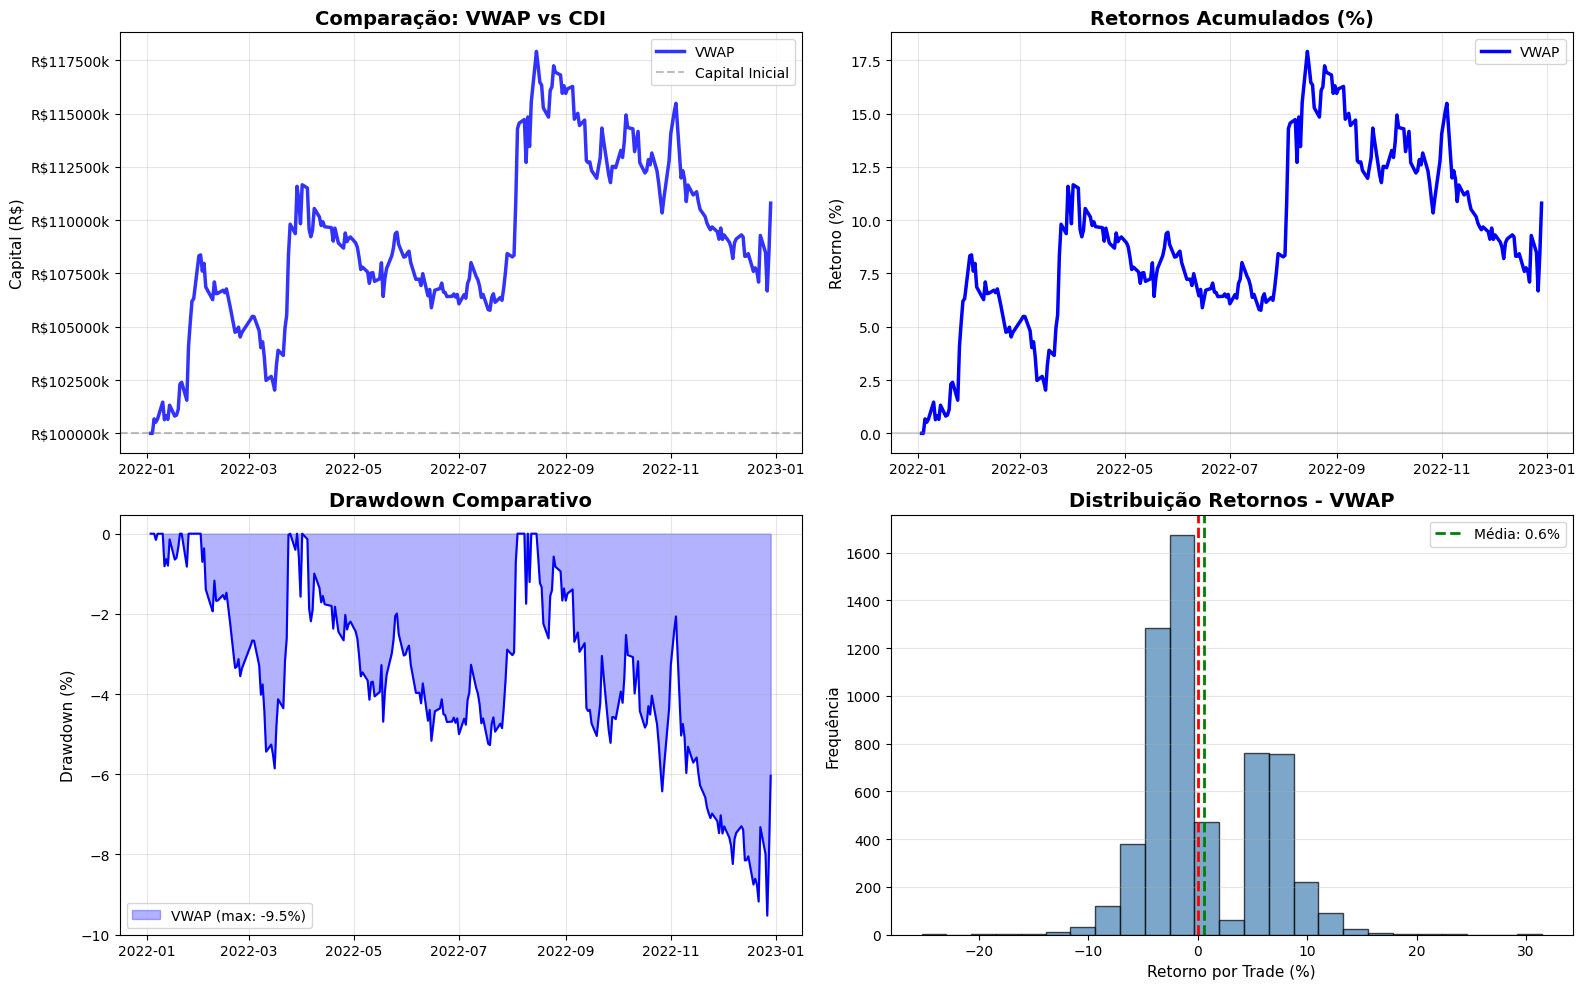


✅ ANÁLISE COMPLETA!


In [8]:
# Download
data = download_data()

if data:
    all_dates = sorted(set(d for df in data.values() for d in df.index))

    # VWAP Strategy
    trades_vwap, equity_vwap = backtest_vwap(data, INITIAL_CAPITAL)

    # Comparação
    visual_strategy(trades_vwap, equity_vwap, INITIAL_CAPITAL)

    print("\n✅ ANÁLISE COMPLETA!")
else:
    print("\n❌ Sem dados disponíveis!")